In [1]:
import torch
import random
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from main import focal_loss,plot_training_metrics,label_smoothing_loss,train,super_class_mapping,class_to_superclass
import matplotlib.pyplot as plt


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("使用设备:", device)

# 查看可用的 GPU 数量
num_gpus = torch.cuda.device_count()
print(f"Available GPUs: {num_gpus}")

# 打印PyTorch和torchvision版本
print("PyTorch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)

使用设备: cuda
Available GPUs: 1
PyTorch version: 2.1.2+cu121
torchvision version: 0.16.2+cu121


In [3]:
# 设置随机种子
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 确保 DataLoader 的 worker 使用相同的随机种子
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# 设置随机种子，确保可复现性
set_seed(4)

In [4]:
# 训练集图像预处理
train_transform = transforms.Compose([
    #transforms.RandomResizedCrop(size=32, scale=(0.8, 1.0)),  # 随机裁剪并缩放到32x32
    transforms.RandomHorizontalFlip(p=0.5),  # 随机水平翻转
    transforms.RandomRotation(degrees=10),  # 随机旋转10度以内
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  # 改变亮度、对比度、饱和度、色调
    transforms.RandAugment(num_ops=2, magnitude=9),  # 使用 RandAugment 自动增强
    transforms.ToTensor(),  # 转为 Tensor 格式
    transforms.Normalize(
        mean=[0.5071, 0.4867, 0.4408],  # CIFAR-100 的均值
        std=[0.2675, 0.2565, 0.2761]  # CIFAR-100 的标准差
    )
])

# 测试集图像预处理（仅标准化处理）
test_transform = transforms.Compose([
    transforms.ToTensor(),  # 转为 Tensor 格式
    transforms.Normalize(
        mean=[0.5071, 0.4867, 0.4408],  # CIFAR-100 的均值
        std=[0.2675, 0.2565, 0.2761]  # CIFAR-100 的标准差
    )
])

In [5]:
root_path = 'data'

# 加载CIFAR-100训练数据集
trainset = torchvision.datasets.CIFAR100(root=root_path, train=True, download=True, transform=train_transform)

# 创建训练数据集的DataLoader，添加 worker_init_fn 参数，确保可复现
trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=32, 
    shuffle=True, 
    num_workers=2, 
    worker_init_fn=seed_worker  # 确保每个 worker 的随机种子可复现
)

# 加载CIFAR-100测试数据集
testset = torchvision.datasets.CIFAR100(root=root_path, train=False, download=True, transform=test_transform)

# 创建测试数据集的DataLoader，同样添加 worker_init_fn 参数
testloader = torch.utils.data.DataLoader(
    testset, 
    batch_size=32, 
    shuffle=False, 
    num_workers=2, 
    worker_init_fn=seed_worker  # 确保每个 worker 的随机种子可复现
)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# 打印训练集和测试集的大小
print(f"训练数据集的大小: {len(trainset)}")
print(f"测试数据集的大小: {len(testset)}")

训练数据集的大小: 50000
测试数据集的大小: 10000


In [7]:
from reslp import ResNet

# 创建更深的模型实例
resnet = ResNet(num_classes=100)  # 对于 CIFAR-100, num_classes 应为 100
resnet.to('cuda')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Identity()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), strid

In [8]:
def train(model, trainloader, testloader, criterion, optimizer, scheduler, super_class_mapping, class_to_superclass, device='cpu', num_epochs=100, use_early_stopping=False):
    """
    Train the model and calculate and print Top-1 accuracy, Top-5 accuracy, and Super-Class accuracy.
    Outputs the best metrics observed during training.
    """
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    start_time = time.time()

    best_test_accuracy = 0.0
    best_epoch_metrics = {}

    no_improvement_count = 0

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        correct_super_class_train = 0
        total_super_class_train = 0

        # Training phase
        model.train()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            # Calculate super-class accuracy (optional)
            for idx, label in enumerate(labels):
                superclass = class_to_superclass[label.item()]
                total_super_class_train += 1
                if predicted[idx].item() in super_class_mapping[superclass]:
                    correct_super_class_train += 1

        train_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        running_test_loss = 0.0
        correct_test = 0
        total_test = 0
        correct_top5 = 0
        correct_super_class_test = 0
        total_super_class_test = 0

        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

                _, top5_preds = outputs.topk(5, dim=1)
                correct_top5 += (top5_preds == labels.view(-1, 1)).sum().item()

                # Calculate super-class accuracy (optional)
                for idx, label in enumerate(labels):
                    superclass = class_to_superclass[label.item()]
                    total_super_class_test += 1
                    if predicted[idx].item() in super_class_mapping[superclass]:
                        correct_super_class_test += 1

        test_loss = running_test_loss / len(testloader)
        test_accuracy = 100 * correct_test / total_test
        top5_accuracy = 100 * correct_top5 / total_test
        super_class_accuracy_test = 100 * correct_super_class_test / total_super_class_test
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        # Print metrics
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.3f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {test_loss:.3f}, '
              f'Test Acc: {test_accuracy:.2f}%, Top-5 Acc: {top5_accuracy:.2f}%, Super-Class Acc: {super_class_accuracy_test:.2f}%')

        # Update learning rate
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Current Learning Rate: {current_lr:.6f}')

        # Store best accuracy and corresponding metrics
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            best_epoch_metrics = {
                'epoch': epoch + 1,
                'train_loss': train_loss,
                'train_accuracy': train_accuracy,
                'test_loss': test_loss,
                'test_accuracy': test_accuracy,
                'top5_accuracy': top5_accuracy,
                'super_class_accuracy': super_class_accuracy_test
            }

        # Early stopping (if required)
        if use_early_stopping:
            if test_accuracy > best_test_accuracy:
                no_improvement_count = 0
            else:
                no_improvement_count += 1

            if no_improvement_count >= patience:
                print(f'Early stopping at epoch {epoch + 1}, best accuracy: {best_test_accuracy:.2f}%')
                break

    total_time = time.time() - start_time
    minutes, seconds = divmod(total_time, 60)
    print(f'Finished Training in {int(minutes)}m {int(seconds)}s')

    # Output best results
    print('Best Test Results:')
    print(f'Epoch {best_epoch_metrics["epoch"]}, Train Loss: {best_epoch_metrics["train_loss"]:.3f}, Train Acc: {best_epoch_metrics["train_accuracy"]:.2f}%, '
          f'Test Loss: {best_epoch_metrics["test_loss"]:.3f}, Test Acc: {best_epoch_metrics["test_accuracy"]:.2f}%, '
          f'Top-5 Acc: {best_epoch_metrics["top5_accuracy"]:.2f}%, Super-Class Acc: {best_epoch_metrics["super_class_accuracy"]:.2f}%')

    return best_epoch_metrics, train_losses, test_losses, train_accuracies, test_accuracies


In [9]:
label_smoothing_loss

<function main.label_smoothing_loss(pred, target, smoothing=0.175)>

In [10]:
from torch.optim.lr_scheduler import CosineAnnealingLR
import time

In [12]:
#label_smoothing_loss，smoothing=0.175，momentum=0.95，bitch_size=32，nesterov=True，ReduceLROnPlateau 调度器
optimizer = optim.SGD(
    resnet.parameters(),
    lr=0.05,              # 初始学习率（通常为最大学习率）
    momentum=0.95,
    weight_decay=0.0001,
    nesterov=True
)
num_epochs=150
steps_per_epoch = len(trainloader)
total_steps = num_epochs * steps_per_epoch

scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)

# 调用训练函数
e,train_losses, test_losses, train_accuracies, test_accuracies = train(
    resnet,
    trainloader,
    testloader,
    label_smoothing_loss,  # 使用标签平滑损失，如果有定义
    optimizer,
    scheduler,             # 添加 scheduler 参数
    super_class_mapping,   # 添加 super_class_mapping
    class_to_superclass,   # 添加 class_to_superclass
    device='cuda',
    num_epochs=150,        # 设置为 100 个 epoch
    use_early_stopping=False  # 根据需要启用或禁用早停法
)


Epoch 1/150, Train Loss: 4.561, Train Acc: 2.58%, Test Loss: 4.295, Test Acc: 5.34%, Top-5 Acc: 21.63%, Super-Class Acc: 14.62%
Current Learning Rate: 0.049995
Epoch 2/150, Train Loss: 4.254, Train Acc: 7.22%, Test Loss: 3.961, Test Acc: 13.94%, Top-5 Acc: 38.80%, Super-Class Acc: 27.02%
Current Learning Rate: 0.049978
Epoch 3/150, Train Loss: 3.973, Train Acc: 13.97%, Test Loss: 3.626, Test Acc: 22.57%, Top-5 Acc: 52.21%, Super-Class Acc: 36.32%
Current Learning Rate: 0.049951
Epoch 4/150, Train Loss: 3.661, Train Acc: 22.06%, Test Loss: 3.268, Test Acc: 32.44%, Top-5 Acc: 64.00%, Super-Class Acc: 47.19%
Current Learning Rate: 0.049912
Epoch 5/150, Train Loss: 3.379, Train Acc: 29.77%, Test Loss: 3.015, Test Acc: 40.55%, Top-5 Acc: 71.93%, Super-Class Acc: 54.72%
Current Learning Rate: 0.049863
Epoch 6/150, Train Loss: 3.178, Train Acc: 35.38%, Test Loss: 2.877, Test Acc: 45.09%, Top-5 Acc: 75.87%, Super-Class Acc: 59.69%
Current Learning Rate: 0.049803
Epoch 7/150, Train Loss: 3.029,

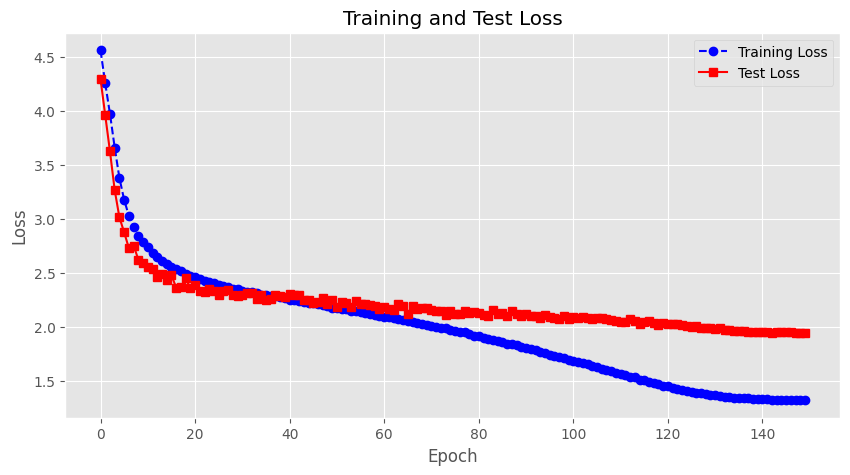

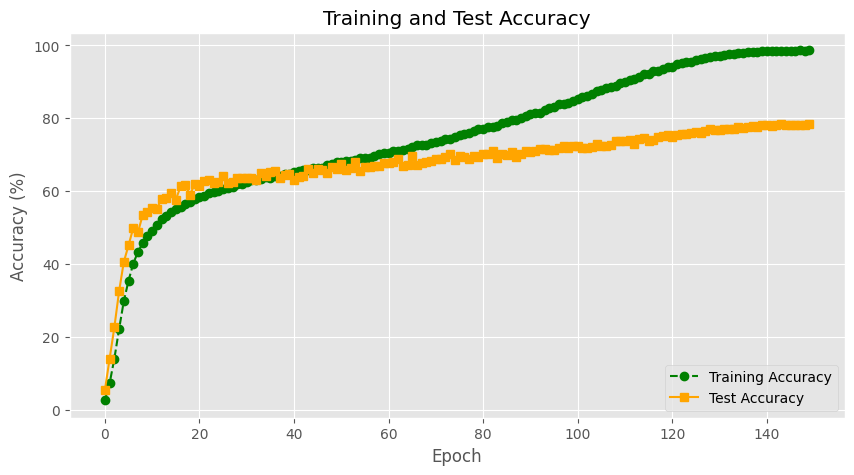

In [13]:
plot_training_metrics(train_losses, test_losses, train_accuracies, test_accuracies)

In [16]:
import torch
import numpy as np

def evaluate_and_report_top_bottom_k(model, testloader, class_names, device='cuda', k=5):
    # CIFAR-100 一共有 100 个类别
    num_classes = len(class_names)

    # 初始化每个类别的正确预测和总样本数统计
    class_correct = np.zeros(num_classes)
    class_total = np.zeros(num_classes)

    model.eval()  # 设置模型为评估模式
    with torch.no_grad():  # 禁用梯度计算
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # 获取预测的类别
            correct = (predicted == labels)  # 预测是否正确

            # 统计每个类别的正确预测数和总样本数
            for i in range(len(labels)):
                label = labels[i].item()  # 真实标签
                class_correct[label] += correct[i].item()  # 累加该类别的正确预测数
                class_total[label] += 1  # 累加该类别的总样本数

    # 计算每个类别的准确率
    class_accuracy = 100 * class_correct / class_total

    # 获取最高准确率的前 k 个类别的索引
    top_k_indices = np.argsort(class_accuracy)[-k:][::-1]  # 降序排列
    # 获取最低准确率的前 k 个类别的索引
    bottom_k_indices = np.argsort(class_accuracy)[:k]  # 升序排列

    # 输出最高的 k 个类别及其准确率
    print(f"Top {k} classes with highest accuracy:")
    for idx in top_k_indices:
        print(f"Class {class_names[idx]}: Accuracy = {class_accuracy[idx]:.2f}%")

    print("\n" + "="*30 + "\n")  # 分隔线

    # 输出最低的 k 个类别及其准确率
    print(f"Bottom {k} classes with lowest accuracy:")
    for idx in bottom_k_indices:
        print(f"Class {class_names[idx]}: Accuracy = {class_accuracy[idx]:.2f}%")

    return class_accuracy


In [17]:
# 假设你已经定义了 resnet 模型和 testloader
# 获取 CIFAR-100 的类别名称
cifar100_classes = torchvision.datasets.CIFAR100(root='data', download=True).classes

# 运行评估并输出最高和最低的5个类别的准确率
evaluate_and_report_top_bottom_k(resnet, testloader, cifar100_classes, device='cuda', k=5)

Files already downloaded and verified
Top 5 classes with highest accuracy:
Class road: Accuracy = 97.00%
Class wardrobe: Accuracy = 96.00%
Class chimpanzee: Accuracy = 93.00%
Class skyscraper: Accuracy = 93.00%
Class keyboard: Accuracy = 93.00%


Bottom 5 classes with lowest accuracy:
Class otter: Accuracy = 48.00%
Class seal: Accuracy = 52.00%
Class girl: Accuracy = 55.00%
Class boy: Accuracy = 57.00%
Class bowl: Accuracy = 58.00%


array([85., 88., 62., 68., 65., 85., 83., 69., 91., 91., 58., 57., 82.,
       73., 77., 86., 72., 84., 76., 65., 88., 93., 79., 87., 82., 72.,
       73., 60., 85., 79., 69., 77., 72., 69., 77., 55., 89., 78., 77.,
       93., 77., 91., 72., 92., 60., 63., 58., 73., 92., 92., 59., 80.,
       72., 89., 77., 48., 90., 77., 88., 71., 83., 80., 75., 77., 62.,
       68., 84., 68., 97., 80., 63., 81., 52., 64., 60., 88., 93., 71.,
       71., 81., 61., 85., 89., 66., 76., 92., 83., 88., 80., 86., 81.,
       84., 64., 69., 96., 75., 72., 83., 59., 82.])

Files already downloaded and verified
Top K Classes:
road: 0.9700
wardrobe: 0.9600
chimpanzee: 0.9300
keyboard: 0.9300
skyscraper: 0.9300

Bottom K Classes:
otter: 0.4800
seal: 0.5200
girl: 0.5500
boy: 0.5700
bowl: 0.5800


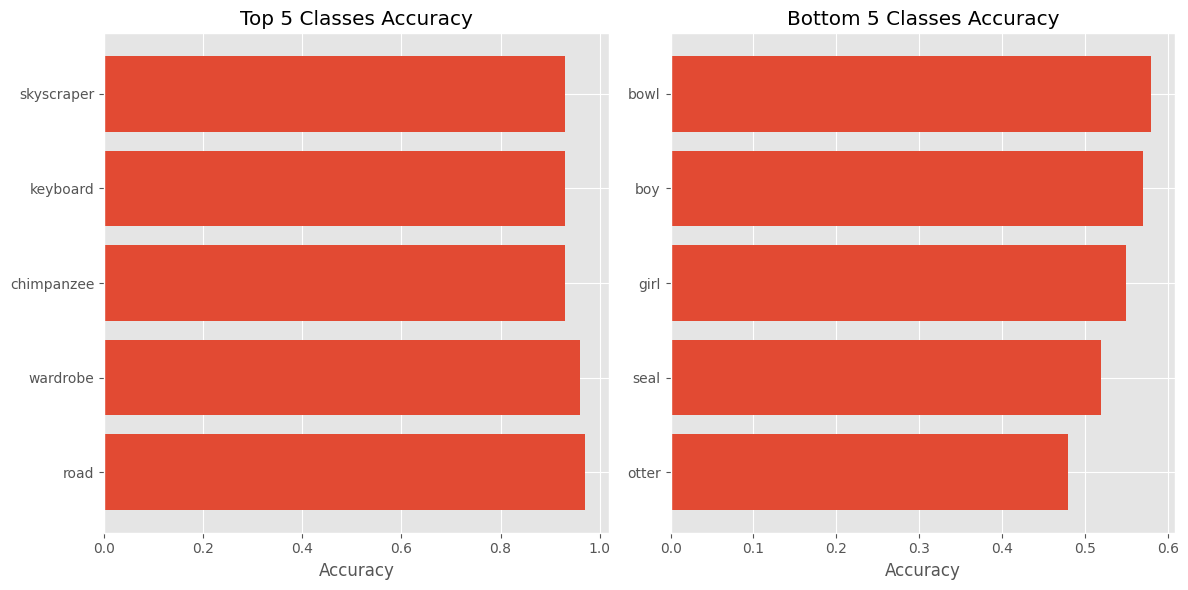

In [18]:
import torch
import torchvision
import matplotlib.pyplot as plt

# 假设你已经定义了 resnet 模型和 testloader
# 获取 CIFAR-100 的类别名称
cifar100_classes = torchvision.datasets.CIFAR100(root='data', download=True).classes

def evaluate_and_report_top_bottom_k(model, dataloader, class_names, device='cuda', k=5):
    model.eval()
    correct = [0] * len(class_names)
    total = [0] * len(class_names)

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # 统计每个类别的正确预测数量
            for i in range(len(labels)):
                total[labels[i]] += 1
                if predicted[i] == labels[i]:
                    correct[labels[i]] += 1

    # 计算每个类别的准确率
    accuracy = [correct[i] / total[i] if total[i] > 0 else 0 for i in range(len(class_names))]

    # 找到最高和最低的 k 个类别
    top_k_indices = sorted(range(len(accuracy)), key=lambda i: accuracy[i], reverse=True)[:k]
    bottom_k_indices = sorted(range(len(accuracy)), key=lambda i: accuracy[i])[:k]

    top_k_accuracy = [accuracy[i] for i in top_k_indices]
    bottom_k_accuracy = [accuracy[i] for i in bottom_k_indices]

    # 输出最高和最低的 k 个类别及其准确率
    print("Top K Classes:")
    for i in top_k_indices:
        print(f"{class_names[i]}: {accuracy[i]:.4f}")

    print("\nBottom K Classes:")
    for i in bottom_k_indices:
        print(f"{class_names[i]}: {accuracy[i]:.4f}")

    return top_k_indices, bottom_k_indices, top_k_accuracy, bottom_k_accuracy

# 运行评估
top_k_indices, bottom_k_indices, top_k_accuracy, bottom_k_accuracy = evaluate_and_report_top_bottom_k(
    resnet, testloader, cifar100_classes, device='cuda', k=5
)

# 绘制图像
def plot_accuracy(top_classes, bottom_classes, top_accuracy, bottom_accuracy, class_names):
    plt.figure(figsize=(12, 6))

    # 绘制最高准确率的类别
    plt.subplot(1, 2, 1)
    plt.barh(range(len(top_classes)), top_accuracy, align='center')
    plt.yticks(range(len(top_classes)), [class_names[i] for i in top_classes])
    plt.xlabel('Accuracy')
    plt.title('Top 5 Classes Accuracy')

    # 绘制最低准确率的类别
    plt.subplot(1, 2, 2)
    plt.barh(range(len(bottom_classes)), bottom_accuracy, align='center')
    plt.yticks(range(len(bottom_classes)), [class_names[i] for i in bottom_classes])
    plt.xlabel('Accuracy')
    plt.title('Bottom 5 Classes Accuracy')

    plt.tight_layout()
    plt.show()

# 绘制准确率图像
plot_accuracy(top_k_indices, bottom_k_indices, top_k_accuracy, bottom_k_accuracy, cifar100_classes)


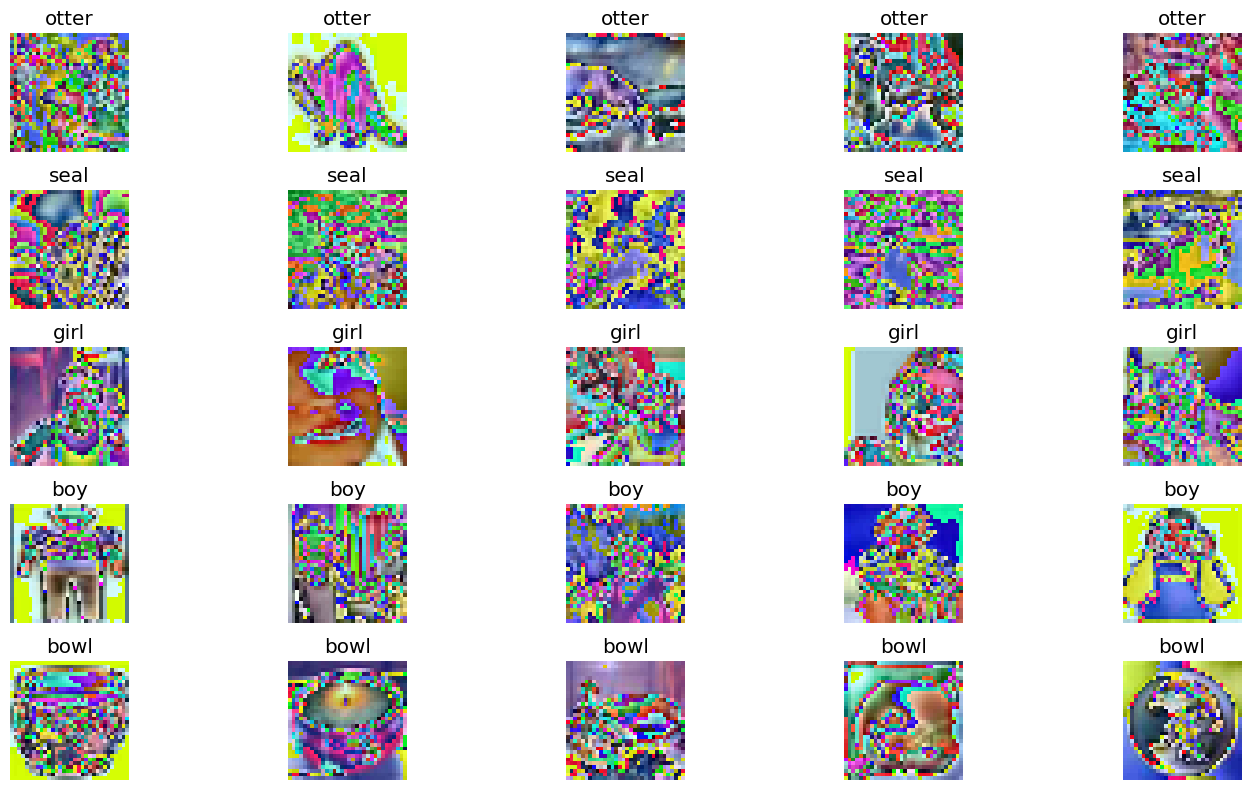

In [19]:
import random
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def show_random_samples_from_bottom_k_classes(model, dataloader, class_names, bottom_k_indices, k=5, device='cuda'):
    # 用于转换图像的函数
    transform = transforms.ToPILImage()
    samples = {class_names[i]: [] for i in bottom_k_indices}

    # 从数据集中收集每个类别的图像
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        
        for i in range(len(labels)):
            if class_names[labels[i]] in samples and len(samples[class_names[labels[i]]]) < k:
                samples[class_names[labels[i]]].append(images[i])

    # 随机选择每个类别的样本
    selected_samples = {cls: random.sample(imgs, min(len(imgs), k)) for cls, imgs in samples.items()}

    # 绘制随机样本
    plt.figure(figsize=(15, 8))
    for i, (cls, imgs) in enumerate(selected_samples.items()):
        for j, img in enumerate(imgs):
            plt.subplot(len(selected_samples), k, i * k + j + 1)
            plt.imshow(transform(img.cpu()))
            plt.axis('off')
            plt.title(cls)

    plt.tight_layout()
    plt.show()

# 调用函数展示最低准确率类别的随机图片
show_random_samples_from_bottom_k_classes(resnet, testloader, cifar100_classes, bottom_k_indices, k=5, device='cuda')


In [10]:
#label_smoothing_loss，smoothing=0.175，momentum=0.95，bitch_size=32，nesterov=True，ReduceLROnPlateau 调度器

# 使用 SGD 优化器
optimizer = optim.SGD(
    resnet.parameters(),
    lr=0.01,
    momentum=0.95,
    weight_decay=0.0001,
    nesterov=True
)

# 训练过程
train_losses, test_losses, train_accuracies, test_accuracies = train(
    resnet, 
    trainloader, 
    testloader, 
    label_smoothing_loss,  # 使用标签平滑损失
    optimizer,
    super_class_mapping,  # 添加super_class_mapping
    class_to_superclass,  # 添加class_to_superclass
    device='cuda', 
    num_epochs=80,  # 设置为30个epoch
    patience=3,  # 即使设置了patience，也不会触发早停法
    min_delta=0.5, 
    use_early_stopping=False  # 不使用早停法
)

Epoch 1/80, Train Loss: 4.260, Train Acc: 9.12%, Test Loss: 3.765, Test Acc: 19.21%, Top-5 Acc: 46.06%, Super-Class Acc: 32.88%
Epoch 2/80, Train Loss: 3.768, Train Acc: 19.78%, Test Loss: 3.356, Test Acc: 31.81%, Top-5 Acc: 62.42%, Super-Class Acc: 46.21%
Epoch 3/80, Train Loss: 3.453, Train Acc: 28.63%, Test Loss: 3.091, Test Acc: 40.05%, Top-5 Acc: 71.64%, Super-Class Acc: 55.00%
Epoch 4/80, Train Loss: 3.229, Train Acc: 35.51%, Test Loss: 2.954, Test Acc: 44.89%, Top-5 Acc: 75.01%, Super-Class Acc: 58.58%
Epoch 5/80, Train Loss: 3.075, Train Acc: 40.23%, Test Loss: 2.847, Test Acc: 49.48%, Top-5 Acc: 78.61%, Super-Class Acc: 62.93%
Epoch 6/80, Train Loss: 2.956, Train Acc: 44.02%, Test Loss: 2.730, Test Acc: 52.44%, Top-5 Acc: 81.58%, Super-Class Acc: 65.15%
Epoch 7/80, Train Loss: 2.874, Train Acc: 46.87%, Test Loss: 2.698, Test Acc: 53.51%, Top-5 Acc: 81.77%, Super-Class Acc: 65.87%
Epoch 8/80, Train Loss: 2.788, Train Acc: 49.52%, Test Loss: 2.626, Test Acc: 56.16%, Top-5 Acc: 8

In [12]:
!pip install torchviz


Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=d88961b48eeca520fcfc0f9eab2ddcefafea2e7ae81554d05ea4b11dcf4a7575
  Stored in directory: /home/elema001/.cache/pip/wheels/5a/d0/3f/b7014553eb74f12892b7d9b69c6083044564712d10fde8dfdc
Successfully built torchviz


In [15]:
import torch
from torchviz import make_dot

# 创建一个ResNet模型实例
model = ResNet(num_classes=100)

# 创建一个输入张量
x = torch.randn(1, 3, 32, 32)  # 假设输入大小为32x32的RGB图像

# 通过模型进行前向传播
y = model(x)

# 可视化神经网络
dot = make_dot(y, params=dict(model.named_parameters()))
dot.render("/hyx/resnet", format="png")  # 保存到/tmp目录




PermissionError: [Errno 13] Permission denied: '/hyx'